In [2]:
import pyodbc
from numpy import vectorize as vt
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime
from os import getcwd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from UliPlot.XLSX import auto_adjust_xlsx_column_width

SQL

In [3]:
# Get GMLA list
cklist_confirm_query = """ 
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,[PROJECT_CATEGORY] as 'Segment'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      ,[status]
      ,[rejectReason]
      /*,[kickOffMeetingDate]*/
      ,[baseOverDueDate] as 'actualCloseMeetingDate'
      ,[submitDate] as 'actualGMLASubmitDate'
      /*,[IsByPass]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_CONFIRM]

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names and segment */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/

  WHERE [IsByPass] = '0'
"""

# Get design review date which sync PM system
project_schedule_query = """ 
SELECT [ProjectSizeId] as 'projectSizeId'
      /*
      ,[PROJECT_NAME]
      ,[T_GT_ProjectSchedule].[TASK_ID]
      */
      ,[DESC_OF_TASK]
      /*
      ,[T_GT_TaskBaseInfo].[Note]
      ,[IsPM]
      */
      ,DATEADD(DAY,-21,[Current_Date]) as 'estCloseMeetingDate'
      /* Design review -21 days */
  FROM [PR_WEB2].[dbo].[T_GT_ProjectSchedule]

  LEFT JOIN [PR_WEB2].[dbo].[T_GT_TaskBaseInfo] 
  ON [T_GT_ProjectSchedule].[TASK_ID] = [T_GT_TaskBaseInfo].TASK_ID

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ProjectSizeId = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID
  
  WHERE DESC_OF_TASK
  IN ('Mechanical Design Review','Factory Prototype Design Review','Pilot Run Design Review')
"""

# Get Project Risk
cklist_issue_query = """
SELECT [T_GMLA_CKLIST_ISSUE].[projectSizeId]
      /*,[PROJECT_CATEGORY] as 'Segment'*/
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      /*,[T_GMLA_CKLIST_ISSUE].[categoryId]*/
      ,[riskType] as 'Risk'
      /*,[categoryName] as 'Category'*/
      /*,[T_GMLA_CKLIST_ISSUE].[id]*/
      /*,[no] as 'No'*/
      /*,[T_GMLA_CKLIST_ISSUE].[status]*/
      /*,[T_GMLA_CKLIST_ISSUE].[updated_at]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_ISSUE]
  
  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names */
  
  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/
  
  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_CATEGORY]
  ON [T_GMLA_CKLIST_ISSUE].categoryId=[T_GMLA_BS_CATEGORY].id
  /* Join 6 category name via id */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_CKLIST]
  ON ([T_GMLA_CKLIST_ISSUE].[categoryId] = [T_GMLA_CKLIST].[categoryId]
  AND [T_GMLA_CKLIST_ISSUE].id = [T_GMLA_CKLIST].id
  AND [T_GMLA_CKLIST_ISSUE].projectSizeId = [T_GMLA_CKLIST].projectSizeId
  AND [T_GMLA_CKLIST_ISSUE].typeId = [T_GMLA_CKLIST].typeId)
  /* Join serval datas */
"""
# Get GMLA score
gmla_cklist_query = """
SELECT [projectSizeId]
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      /*,[categoryId]
      ,[no]*/
      ,[result]
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST]
  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON [T_GMLA_CKLIST].typeId = [T_GMLA_BS_VERSION_TYPE].id
"""

In [4]:
connection_string = "DRIVER={SQL Server};SERVER=T1-PE-SUPPORT;DATABASE=PR_WEB2;UID=pieng;PWD=Q2iT5cwHJW3FH"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

cklist_confirm = pd.read_sql(cklist_confirm_query, engine)
project_schedule = pd.read_sql(project_schedule_query, engine, parse_dates='estCloseMeetingDate')
cklist_issue = pd.read_sql(cklist_issue_query, engine)
gmla_cklist = pd.read_sql(gmla_cklist_query, engine)

Hanlde cklist_issue for project risk info.

In [5]:
# Risk 4 = blue 1 star = Risk 2, replace blue star
cklist_issue.Risk.replace(to_replace= 4,value = 2, inplace=True)

In [6]:
cklist_issue = cklist_issue.sort_values('Risk', ascending=False).drop_duplicates(subset=['projectSizeId','Project_Name','Phase'], keep='first').sort_values('projectSizeId')

Handle cKlist_confirm

In [7]:
cklist_confirm.replace('0001-01-08 00:00:00.0000000 +08:00', None, inplace=True)

In [8]:
cklist_confirm.actualCloseMeetingDate = pd.to_datetime(cklist_confirm.actualCloseMeetingDate, utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.actualGMLASubmitDate = pd.to_datetime(cklist_confirm.actualGMLASubmitDate,utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.head()

,projectSizeId,Project_Name,Segment,Phase,status,rejectReason,actualCloseMeetingDate,actualGMLASubmitDate
0,766,GAD 13,Aviation,GMLA1,0,None,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,0,None,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,0,None,NaT,NaT
3,775,zumo X,Automotive,GMLA1,0,None,NaT,NaT
4,775,zumo X,Automotive,GMLA2,0,None,NaT,NaT


Merge project_schedule

In [9]:
project_schedule.estCloseMeetingDate = project_schedule.estCloseMeetingDate.dt.tz_convert('Asia/Taipei')

In [10]:
project_schedule['Phase'] = project_schedule.DESC_OF_TASK.map(
    {'Mechanical Design Review':'GMLA1','Factory Prototype Design Review':'GMLA2','Pilot Run Design Review':'GMLA3'})
project_schedule.drop_duplicates(subset=['projectSizeId','Phase'], inplace=True)
# Some project have multi-design review date in PMsystem

In [11]:
overall = pd.merge(left=cklist_confirm, right=project_schedule, how='left', on=['projectSizeId','Phase'])
overall.drop('DESC_OF_TASK', axis=1, inplace=True)

In [12]:
def mergeCloseMeeting(actualCloseMeetingDate, estCloseMeetingDate):
    if actualCloseMeetingDate is pd.NaT:
        return estCloseMeetingDate
    else:
        return actualCloseMeetingDate
overall['mergedCloseMeetingDate'] = vt(mergeCloseMeeting)(overall.actualCloseMeetingDate, overall.estCloseMeetingDate)

In [13]:
overall['targetGMLASubmitDate'] = (overall.mergedCloseMeetingDate + BDay(8)).dt.date

overall.iloc[:,6:] = overall.iloc[:,6:].apply(lambda time: pd.to_datetime(time).dt.date)

In [14]:
def on_time(actualDate, targetDate):
    if actualDate is pd.NaT or targetDate is pd.NaT:
        return None
    elif actualDate > targetDate:
        return 0
    else:
        return 1
overall['on_time'] = vt(on_time)(overall.actualGMLASubmitDate, overall.targetGMLASubmitDate)

Merge cklist_issue to get "Risk"

In [15]:
overall = pd.merge(left=overall, right=cklist_issue, on=['projectSizeId','Project_Name','Phase'], how='left')

In [16]:
def define_risk(status, risk):
    if status == 1:
        if risk == 3:
            return 'Red'
        elif risk == 2:
            return "Yellow"
        else:
            return "Green"
    else:
        pass

overall.Risk = vt(define_risk)(overall.status, overall.Risk)

Handle delay_but_rejected projects


In [17]:
def delay_but_rejected(on_time, rejectReason):
    if on_time is None:
        return None
    elif on_time == False and rejectReason != None:
        return 1
    else:
        return 0
overall['delay_but_rejected'] = vt(delay_but_rejected)(overall['on_time'], overall['rejectReason'])

In [18]:
overall.head()

,projectSizeId,Project_Name,Segment,Phase,status,rejectReason,actualCloseMeetingDate,actualGMLASubmitDate,estCloseMeetingDate,mergedCloseMeetingDate,targetGMLASubmitDate,on_time,Risk,delay_but_rejected
0,766,GAD 13,Aviation,GMLA1,0,None,NaT,NaT,NaT,NaT,NaT,None,None,None
1,766,GAD 13,Aviation,GMLA2,0,None,NaT,NaT,NaT,NaT,NaT,None,None,None
2,766,GAD 13,Aviation,GMLA3,0,None,NaT,NaT,NaT,NaT,NaT,None,None,None
3,775,zumo X,Automotive,GMLA1,0,None,NaT,NaT,2019-04-15,2019-04-15,2019-04-25,None,None,None
4,775,zumo X,Automotive,GMLA2,0,None,NaT,NaT,NaT,NaT,NaT,None,None,None


Get GMLA score and merge to overall

In [19]:
# Result 3 = complete, 1 = incomplete, 2 = yellow light, 0 = GMLA is open
gmla_cklist.result = gmla_cklist.result.map({3:1, 1:0, 2:0})
# Replace 3 as 1, 2, 1 as 0 , meaning 1 is complete, 0 is incomplete, to agg below
gmla_score = gmla_cklist.groupby(['projectSizeId','Phase']).agg({'Phase':'count','result':'sum'})
gmla_score.rename(columns={'Phase':'totalProject'}, inplace=True)
gmla_score['Score'] = 100*(gmla_score.result / gmla_score.totalProject).round(4)
gmla_score.reset_index(inplace=True)
gmla_score

,projectSizeId,Phase,totalProject,result,Score
0,766,GMLA1,15,0.0,0.0
1,766,GMLA2,45,0.0,0.0
2,766,GMLA3,47,0.0,0.0
3,767,GMLA1,15,0.0,0.0
4,767,GMLA2,45,0.0,0.0
...,...,...,...,...,...
808,1130,GMLA2,44,0.0,0.0
809,1130,GMLA3,47,0.0,0.0
810,1131,GMLA1,12,0.0,0.0
811,1131,GMLA2,44,0.0,0.0


In [20]:
overall = pd.merge(left=overall, right=gmla_score[['projectSizeId','Phase','Score']], on=['projectSizeId','Phase'], how='left')

In [21]:
overall

,projectSizeId,Project_Name,Segment,Phase,status,rejectReason,actualCloseMeetingDate,actualGMLASubmitDate,estCloseMeetingDate,mergedCloseMeetingDate,targetGMLASubmitDate,on_time,Risk,delay_but_rejected,Score
0,766,GAD 13,Aviation,GMLA1,0,None,NaN,NaN,NaT,NaT,NaT,None,None,None,0.0
1,766,GAD 13,Aviation,GMLA2,0,None,NaN,NaN,NaT,NaT,NaT,None,None,None,0.0
2,766,GAD 13,Aviation,GMLA3,0,None,NaN,NaN,NaT,NaT,NaT,None,None,None,0.0
3,775,zumo X,Automotive,GMLA1,0,None,NaN,NaN,2019-04-15,2019-04-15,2019-04-25,None,None,None,0.0
4,775,zumo X,Automotive,GMLA2,0,None,NaN,NaN,NaT,NaT,NaT,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1130,Premium Dash Cams,Automotive,GMLA2,0,None,NaN,NaN,2023-04-19,2023-04-19,2023-05-01,None,None,None,0.0
565,1130,Premium Dash Cams,Automotive,GMLA3,0,None,NaN,NaN,2023-06-16,2023-06-16,2023-06-28,None,None,None,0.0
566,1131,Drive 53,Automotive,GMLA1,0,None,NaN,NaN,NaT,NaT,NaT,None,None,None,0.0
567,1131,Drive 53,Automotive,GMLA2,0,None,NaN,NaN,2022-08-23,2022-08-23,2022-09-02,None,None,None,0.0


Complete_rate

In [22]:
complete_rate = overall.copy()
complete_rate = complete_rate[complete_rate.actualGMLASubmitDate.notnull()]
# Resample
complete_rate['targetGMLASubmitDate'] = pd.to_datetime(complete_rate['targetGMLASubmitDate'])
complete_rate = complete_rate.set_index('targetGMLASubmitDate').resample(rule='BM').agg({'Project_Name':'count','status':'sum'})
complete_rate['complete_rate'] = 100*(complete_rate.status / complete_rate.Project_Name)

On-time_rate

In [23]:
on_time_rate = overall.copy()
on_time_rate = on_time_rate[on_time_rate.status == 1] #Select compelted GMLAs
# Resample
on_time_rate.targetGMLASubmitDate = pd.to_datetime(on_time_rate.targetGMLASubmitDate)
on_time_rate = on_time_rate.set_index('targetGMLASubmitDate').resample(rule='BM').agg({'Project_Name':'count','on_time':'sum','delay_but_rejected':'sum'})
on_time_rate.rename(columns={'Project_Name':'total_projects','on_time':'on_time_projects','rejectReason':'rejcted_projects'}, inplace=True)
on_time_rate['on_time_rate'] = (100* (on_time_rate.on_time_projects / on_time_rate.total_projects))
on_time_rate['actual_on_time_rate'] = (100* ((on_time_rate.on_time_projects+ on_time_rate.delay_but_rejected) / on_time_rate.total_projects))

In [24]:
# Show delayed projects

#delayed_projects = overall[(overall.on_time == False)].sort_values('targetGMLASubmitDate')
#delayed_projects.to_excel(writer, sheet_name='delayed_projects')

In [25]:
#actual_delayed_projects = overall[(overall.on_time == False) & (overall.delay_but_rejected == False)].sort_values('targetGMLASubmitDate')
#actual_delayed_projects.to_excel(writer, sheet_name='Actual_delayed_projects')

Show final results

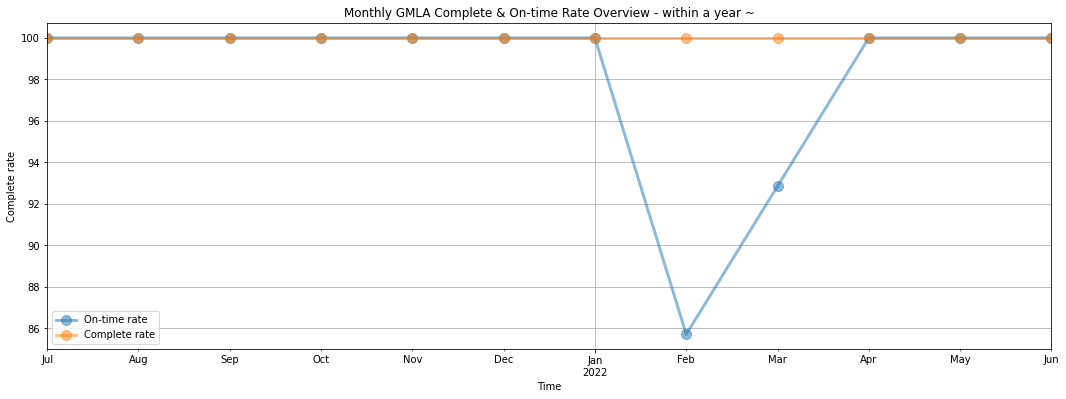

In [26]:
# Draw one year data
ax = on_time_rate[datetime.now()-pd.DateOffset(years=1):datetime.now()].actual_on_time_rate.plot(figsize=(18,6), marker='o', markersize=10 ,lw=3, grid=True, alpha=0.5, label = 'On-time rate')
ax2 = complete_rate[datetime.now()-pd.DateOffset(years=1):datetime.now()].complete_rate.plot(figsize=(18,6), marker='o', markersize=10 ,lw=3, grid=True, alpha=0.5, label = 'Complete rate')
ax.set_xlabel('Time');
ax.set_ylabel('Complete rate');
ax.set_title('Monthly GMLA Complete & On-time Rate Overview - within a year ~');
plt.legend()
plt.savefig(getcwd()+'\Complete and on_time rate',bbox_inches = "tight")

In [27]:
overall_show = overall[['projectSizeId','Segment','Project_Name','Phase','Risk','Score','status','actualCloseMeetingDate','estCloseMeetingDate','mergedCloseMeetingDate','targetGMLASubmitDate','actualGMLASubmitDate','on_time','delay_but_rejected']].set_index('projectSizeId').sort_index().sort_values(['Project_Name','Phase'])
overall_show.status = overall_show.status.map({1:'Complete',0:'Incomplete'})
overall_show.on_time = overall_show.on_time.map({1:'Y',0:'N'})

Excel writer

In [28]:

with pd.ExcelWriter(getcwd()+'\data.xlsx', engine='openpyxl') as writer:
    overall_show.to_excel(writer, sheet_name='overall')
    auto_adjust_xlsx_column_width(overall_show, writer, sheet_name="overall", margin=5)
    
    complete_rate.to_excel(writer, sheet_name='complete_rate')
    auto_adjust_xlsx_column_width(complete_rate, writer, sheet_name="complete_rate", margin=5)
    
    on_time_rate.to_excel(writer, sheet_name='on_time_rate')
    auto_adjust_xlsx_column_width(on_time_rate, writer, sheet_name="on_time_rate", margin=5)